In [143]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [162]:
def read_epochs_from_dir(dir_path):
    epochs = []
    for file in os.listdir(dir_path):
        if file.endswith(".fif"):
            epochs.append(mne.read_epochs(os.path.join(dir_path, file)))
    return epochs

In [163]:
epochs = read_epochs_from_dir("/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs")

In [164]:
all_epochs = mne.concatenate_epochs(epochs)
all_epochs

Number of events,340
Events,digit 1 shown: 68digit 2 shown: 68digit 3 shown: 68digit 4 shown: 68digit 5 shown: 68
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


In [165]:
epochs[0]

Number of events,30
Events,digit 1 shown: 6digit 2 shown: 6digit 3 shown: 6digit 4 shown: 6digit 5 shown: 6
Time range,-0.200 – 0.500 s
Baseline,-0.200 – 0.000 s


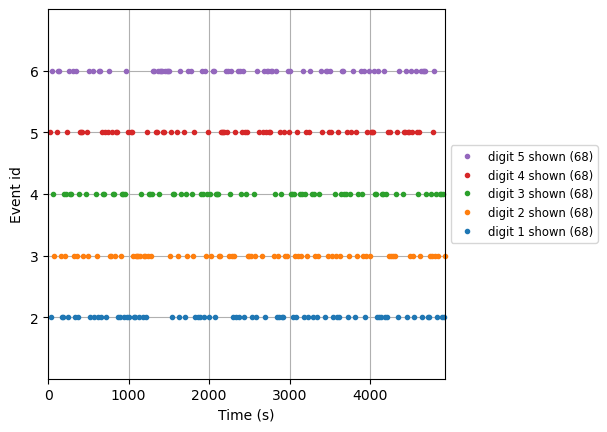

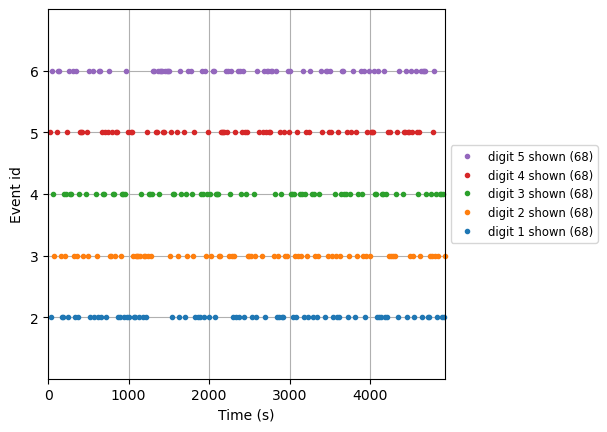

In [171]:
events = all_epochs.events

# Create an event dictionary from the epochs object
event_dict = all_epochs.event_id

# Plot the events
mne.viz.plot_events(events, event_id=event_dict, sfreq=all_epochs.info["sfreq"])

In [172]:
not_preprocessed_data = all_epochs.get_data()
labels = all_epochs.events[:, 2]
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [173]:
X.shape, y.shape

((340, 21, 176), (340,))

In [153]:
np.unique(labels - 1)

array([1, 2, 3, 4, 5], dtype=int32)

In [154]:
labels = labels - 1

In [181]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def perform_grid_search(X, y):
    print("Starting the grid search process...")

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Reshape the data if necessary (assuming X is of shape (n_samples, n_channels, n_times))
    print("Reshaping the data...")
    n_samples, n_channels, n_times = X_train.shape
    X_train_reshaped = X_train.reshape(n_samples, -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    print(f"Training data shape: {X_train_reshaped.shape}")
    print(f"Test data shape: {X_test_reshaped.shape}")

    # Standardize the data
    print("Standardizing the data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)
    print("Data standardization complete.")

    # Define the parameter grid for each model
    # param_grid_svc = {
    #     'clf__C': [0.1, 1, 10, 100],
    #     'clf__gamma': [0.01, 0.001, 0.0001],
    #     'clf__kernel': ['linear', 'rbf']
    # }

    param_grid_rf = {
        'clf__n_estimators': [10, 50, 100],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10]
    }

    param_grid_knn = {
        'clf__n_neighbors': [3, 5, 7, 9],
        'clf__weights': ['uniform', 'distance']
    }

    # param_grid_lr = {
    #     'clf__C': [0.1, 1, 10, 100],
    #     'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
    # }

    # Define the models
    models = {
        # 'SVC': (SVC(), param_grid_svc),
        'RandomForest': (RandomForestClassifier(), param_grid_rf),
        'KNeighbors': (KNeighborsClassifier(), param_grid_knn),
        # 'LogisticRegression': (LogisticRegression(max_iter=1000), param_grid_lr)
    }

    best_models = {}

    # Perform grid search for each model
    for model_name, (model, param_grid) in models.items():
        print(f"Starting grid search for {model_name}...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

    print("Grid search process complete.")
    return best_models, X_test_scaled, y_test

In [175]:
def create_epochs_for_digits(data_dir, output_dir=None, digit_events=('digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown'), to_ica=False, to_ica_dir="ica"):

    files = [f for f in os.listdir(data_dir) if f.endswith('.fif')]
    epochs = []
    for file in files:
        file_path = os.path.join(data_dir, file)
        raw = mne.io.read_raw_fif(file_path, preload=True)
        events = mne.find_events(raw)

        # Print found events for debugging
        print(f"Events found in file {file}: {events}")

        event_dict = {
            'digit 1 shown': 1,
            'digit 2 shown': 2,
            'digit 3 shown': 3,
            'digit 4 shown': 4,
            'digit 5 shown': 5
        }
        events, event_dict = mne.events_from_annotations(raw)

        selected_event_dict = {k: v for k, v in event_dict.items() if k in digit_events}

        try:
            epochs.append(mne.Epochs(raw, events, event_id=selected_event_dict, tmin=-0.2, tmax=0.5, baseline=(None, 0)))
        except ValueError as e:
            print(f"Error processing file {file}: {e}")
        
    return epochs

In [176]:
import mne
import numpy as np

def load_single_ica_epoch(ica_path, epoch_path, labels):
    """
    Load a single ICA and epochs file, apply ICA, and return data and labels as NumPy arrays.

    Parameters:
    ica_path (str): Path to the ICA .fif file.
    epoch_path (str): Path to the Epochs .fif file.
    labels (list of str): List of annotation labels to filter.

    Returns:
    X (numpy.ndarray): Data array.
    y (numpy.ndarray): Labels array.
    """
    # Load the ICA object
    ica = mne.preprocessing.read_ica(ica_path)
    
    # Load the epochs object
    epochs = mne.read_epochs(epoch_path, preload=True)

    # Apply ICA to epochs
    ica.apply(epochs)

    # Create a dictionary to map labels to event IDs
    label_to_event_id = {label: i+1 for i, label in enumerate(labels)}

    # Filter epochs by the specified labels
    selected_epochs = []
    selected_events = []

    for label, event_id in label_to_event_id.items():
        if label in epochs.event_id:
            epochs_for_label = epochs[label]
            selected_epochs.append(epochs_for_label)
            selected_events.append(epochs_for_label.events)
    
    if selected_epochs:
        selected_epochs = mne.concatenate_epochs(selected_epochs)
        X = selected_epochs.get_data()
        y = np.concatenate(selected_events, axis=0)[:, 2]
    else:
        X = np.array([])
        y = np.array([])

    return X, y

# ica_path = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/ica/DJ001.ica.fif'
# epoch_path = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs/DJ001.epo.fif'
# label_list = ['digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown']

# X, y = load_single_ica_epoch(ica_path, epoch_path, label_list)

# print("Data shape:", X.shape)
# print("Labels shape:", y.shape)


In [177]:
# ica_directory = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/ica'
# epochs_directory = '/home/grzesiek/documents/programming/projects/eeg_digit_classification/data/epochs'
# label_list = ['digit 1 shown', 'digit 2 shown', 'digit 3 shown', 'digit 4 shown', 'digit 5 shown']

# X, y = load_and_concat_ica_epochs(ica_directory, epochs_directory, label_list)

# print("Data shape:", X.shape)
# print("Labels shape:", y.shape)

In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(not_preprocessed_data, labels, test_size=0.25, random_state=42)

In [179]:
best_models = perform_grid_search(X_train, y_train)

Starting the grid search process...
Reshaping the data...
Data reshaped to (255, 2816)
Standardizing the data...
Data standardization complete.
Starting grid search for RandomForest...


Best parameters for RandomForest: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 10}
Best cross-validation score for RandomForest: 0.23137254901960785
Completed grid search for RandomForest.

Starting grid search for KNeighbors...
Best parameters for KNeighbors: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best cross-validation score for KNeighbors: 0.23529411764705888
Completed grid search for KNeighbors.

Grid search process complete.


In [180]:
def apply_ica(data):
    """
    Apply FastICA to the data.

    Parameters:
    data (numpy.ndarray): Input data array with shape (n_epochs, n_channels, n_times).

    Returns:
    ica_data (numpy.ndarray): ICA-transformed data array with the same shape as input.
    """
    n_epochs, n_channels, n_times = data.shape
    
    ica = FastICA(n_components=n_channels, random_state=0)
    
    data_2d = data.reshape(n_epochs * n_times, n_channels)
    
    ica_data_2d = ica.fit_transform(data_2d)
    
    ica_data = ica_data_2d.reshape(n_epochs, n_times, n_channels)
    
    ica_data = np.transpose(ica_data, (0, 2, 1))

    return ica_data

In [141]:
ica_data = apply_ica(not_preprocessed_data)

print("Original data shape:", not_preprocessed_data.shape)
print("ICA-transformed data shape:", ica_data.shape)

Original data shape: (340, 21, 176)
ICA-transformed data shape: (340, 21, 176)


In [161]:
X_train.shape

(255, 21, 176)

In [182]:
best_models, X_test_scaled, y_test = perform_grid_search(ica_data, labels)

for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for {model_name}: {accuracy}")

Starting the grid search process...
Reshaping the data...
Training data shape: (272, 3696)
Test data shape: (68, 3696)
Standardizing the data...
Data standardization complete.
Starting grid search for RandomForest...
Best parameters for RandomForest: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 50}
Best cross-validation score for RandomForest: 0.24282828282828284
Starting grid search for KNeighbors...
Best parameters for KNeighbors: {'clf__n_neighbors': 3, 'clf__weights': 'distance'}
Best cross-validation score for KNeighbors: 0.23198653198653202
Grid search process complete.
Test accuracy for RandomForest: 0.23529411764705882
Test accuracy for KNeighbors: 0.1323529411764706
